<a href="https://colab.research.google.com/github/Amelbnmbh/Data-wrangling-housing-/blob/main/WS2Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chaîne de traitement _data science_.
## _pipeline ML_ avec `python` ([`scipy`](https://www.scipy.org/), [`scikit-learn`](https://scikit-learn.org/))


__Dépendance__ : Ce Workshop doit être réalisé après celui sur le _data wrangling_.

Nous allons essayer, dans le cadre de ce workshop, d'entraîner, de configurer et d'utiliser des algorithmes _ML_ de régression. Nous tâcherons systématiquement d'en discuter les performances en nous appuyant sur des indicateurs pertinents.

On rappelle que le _dataset_ présente des données immobilières californiennes. Il compte des variables telles que la population, le salaire médian, le prix moyen d'un logement, _etc_. Et ce pour chaque _block group_ (le _block group_ est la plus petite division administrative aux Etats-Unis - entre 500 et 5000 personnes).

### Rappel des objectifs

On cherche à mettre au point un modèle de prédiction du prix médian d'un logement en fonction des autres informations. C'est clairement un problème [_supervisé_](https://fr.wikipedia.org/wiki/Apprentissage_supervis%C3%A9) de [_régression multivarié_](https://fr.wikipedia.org/wiki/R%C3%A9gression_lin%C3%A9aire_multiple).

### Mesure de performance

On s'intéressera à terme à la minimisation de la [_root mean squared error (RMSE)_](https://en.wikipedia.org/wiki/Root-mean-square_deviation) et/ou de à la [_mean absolute error (MAE)_](https://en.wikipedia.org/wiki/Mean_absolute_error) de notre modèle :

$$
\newcommand\x{\mathbf{x}}
\newcommand\X{\mathbf{X}}
\newcommand\y{\mathbf{y}}
\newcommand\Y{\mathbf{Y}}
\newcommand\RMSE{\mbox{RMSE}}
\newcommand\MAE{\mbox{MAE}}
$$
$$
\RMSE(\X,h)=\sqrt{\frac{1}{m}\sum_{i=1}^{m}{(h(\x^{(i)})-y^{(i)})^2}}
$$

$$
\MAE(\X,h)=\frac{\sum_{i=1}^{m}{\lvert h(\x^{(i)})-y^{(i)})\rvert}}{m}
$$

$h$ étant la fonction de prédiction du modèle. Nous y revidenront plus bas.


### Préparation de l'environnement

In [58]:
# compatibilité python 2 et python 3
from __future__ import division, print_function, unicode_literals

# imports
import numpy as np
import os

# stabilité du notebook d'une exécution à l'autre
np.random.seed(42)

# jolies figures directement dans le notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# où sauver les figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "workflowDS"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID) # le dossier doit exister

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# ignorer les warnings inutiles (voir SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Reconstruction de l'environnement de fin de la première partie du _Workshop_

On va reconstituer le _kernel_ `python` de la première partie du _Workshop_. Vous pouvez executer le code sans vous soucier de son contenu jusqu'à la partie _Choisir et Entraîner un modèle_.

#### Import et chargement

In [59]:
import os
import tarfile
from six.moves import urllib
import pandas as pd

DOWNLOAD_ROOT = "https://github.com/ph10r/eiSpeInfoDS/raw/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

#### _Split_

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True) # replace where false

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

housing = strat_train_set.copy()

<ipython-input-60-46891861333f>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True) # replace where false


#### Pipeline de préparation

In [61]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num = housing.select_dtypes(include=[np.number])
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

### Choisir et Entraîner un modèle

Le travail effectué lors du précédent _workshop_ a abouti à plusieurs résultats :

- Nous avons réservé un jeu de données de test stratifié `strat_test_set`,
- nous en avons extrait les variables d'entrée `housing` et la colonne cible `housing_labels`,
- nous avons créé un _pipeline_ `full_pipeline` de préparation de la donné d'entraînement.
- nous avons utilisé ce _pipeline_ pour façonner un jeu de données `housing_prepared`.

Il est naturel de vouloir maintenant entrer dans le vif du sujet : le _Machine Learning_.

Entraînons un modèle de [_régression linéaire_](https://fr.wikipedia.org/wiki/R%C3%A9gression_lin%C3%A9aire) avec nos données.

#### Premier modèle

In [62]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

C'est tout.
Notre modèle est prêt à faire des prédiction.
> **Remarque**: Nous allons lui présenter des données du jeux d'entraînement en prenant soin d'y appliquer
le _pipeline_ de transformation, comme nous le ferions avec des données nouvelles. Utiliser directement des données de `housing_prepared` menerait au même résultat mais la démarche ne serait pas transposable à d'autre données de test.

In [63]:
# On applique le full_pipeline sur quelques instances :
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

# Et on effectue la prédiction :
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


On peut comparer ces prédictions aux vraies valeurs :

In [64]:
print("Labels:", list(some_labels)) # vraies valeurs

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


### Evaluer / valider un modèle

Nos résultats ne semblent pas abérrants _au premier coup d'oeil_, mais il est naturel de chercher à quantifier notre erreur. C'est là qu'interviennent la [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation) et la [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error).

#### Mesures de performance

Pour rappel
$
\RMSE(\X,h)=\sqrt{\frac{1}{m}\sum_{i=1}^{m}{(h(\x^{(i)})-y^{(i)})^2}}
$
et
$
\MAE(\X,h)=\frac{1}{m}\sum_{i=1}^{m}{\lvert h(\x^{(i)})-y^{(i)})\rvert}
$

Il est bon de s'arrêter un instant pour comprendre ces formules. Toutes deux se ressemblent :

- on prend pour chaque valeur prédite la distance algébrique à la vrai valeur,
- on la transforme en une valeur positive pour obtenir une distance: soit en élevant au carré, soit _via_ la valeur absolue,
- on fait la moyenne de toutes ces distances,
- on passe à la racine carré dans le premier cas par souci d'échelle et de lisibilité.

L'intuition peut donc appréhender ces mesures comme étant des quantifications de l'erreur moyenne d'un modèle prédictif. La première pénalisera fortement les erreurs importantes et sera indulgente envers les erreurs faibles.

`scikit-learn` facilite le calcul de ces métrique, par exemple grâce à la fonction [`mean_squared_error`](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error).

In [65]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

En exercice, on peut explorer [une partie de la documentation](https://scikit-learn.org/stable/modules/model_evaluation.html) de `scikit-learn` pour calculer la _MAE_ :

In [66]:
from sklearn.metrics import mean_absolute_error
lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49438.66860915802

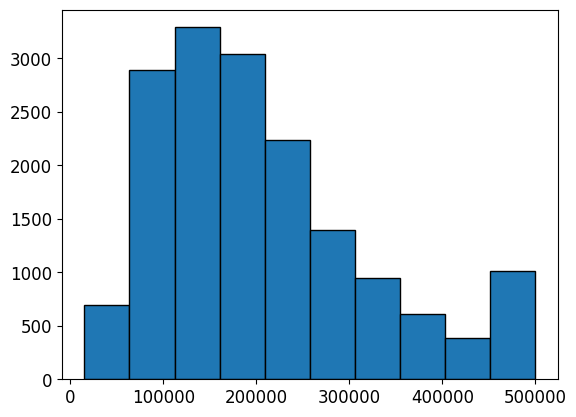

In [67]:
housing_labels.hist(edgecolor='black', grid=False)
plt.show()

Ce n'est pas un résultat satisfaisant, en effet, on voit, en explorant les données, que la majorité des districts ont une `median_housing_value` comprise entre 120 et 265 mille dollars, une erreur typique de 68 mille dollars peut être acceptée par aucun client.

> **Remarque** : il est encore trop tôt pour utiliser le jeu de test. En effet, nous sommes encore dans le processus d'élaboration d'un modèle performant. S'il on avait recours trop souvent au jeu de test durant cette phase, on courrait le risque d'obtenir un modèle _spécialisé_ pour ce je de test-là. Il serait sur-évalué et ne généraliserait pas _en production_ avec des scores similaires.

> On garde à l'esprit : pas de _data snooping_ !

On est en situation de _sous-apprentissage_ (ou _under-fitting_). Cela signifie :

- soit que les données livrées à l'algorithmes d'apprentissage ne contiennent pas l'information permettant l'apprentissage,
- soit que le modèle en lui-même n'est pas assez puissant pour capter toute l'information du jeu d'entraînement.

Pour progresser, nous pouvons considérer plusieurs approches :

1. soit relâcher les contraintes exercées sur les paramètres de notre modèle,
1. soit modifier nos données d'entrée (par exemple : en ajoutant des variables, en passant les données dont l'histogramme est _tail-heavy_ au logarithme, _etc_.),
1. soit sélectionner un modèle plus puissant,

La première solution n'est pas envisageable ici car le modèle utilisé n'est pas hyper-paramétré. La deuxième n'est pas totalement exclue, mais il est trop tôt pour remettre en question notre (bon) travail du _Workshop_ précédent.


#### Un modèle plus puissant

Nous allons donc essayer un modèle plus puissant : un [_arbre de décision_](https://fr.wikipedia.org/wiki/Arbre_de_d%C3%A9cision_(apprentissage)) implémenté dans `scikit-learn` par [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). A vous de créer est d'entraîner ce modèle. Pensez à initialiser la graine aléatoire du modèle (à $42$, bien évidemment) _via_ le paramètre `random_state` de son constructeur.

In [68]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

Notre modèle est entraîné : on peut l'évaluer (toujours sur le traîning set, bien évidemment) et calculer l'erreur-type.

In [69]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Avons-nous bien lu !? Pas d'erreur ? Le modèle parfait ?

Il est bien plus probable que nous soyons en situation de [_sur-apprentissage_](https://fr.wikipedia.org/wiki/Surapprentissage) (ou _over-fitting_), le modèle, trop puissant, a pu se contenter d'apprendre _par coeur_ toutes nos données d'entraînement. Il est peu vraissemblale que cette stratégie _généralise_ sur des données nouvelles.

On pourrait prouver cette théorie avec le jeu de test mais l'on s'est interdit de l'utiliser avant d'avoir la conviction que notre modèle était performant... Alors que faire ?

Nous allons utiliser une partie du jeu d'entraînement pour entraîner à proprement dit, et une autre pour valider les modèles : c'est ce que l'on appelle la [_validation croisée_](https://fr.wikipedia.org/wiki/Validation_crois%C3%A9e) (ou _cross-validation_).

#### Validation croisée

On pourrait utiliser à nouveau `train_test_split` mais `scikit-learn` propose une [fonctionalité](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) de $k$-_fold cross validation_. Ce qui consiste à :

- diviser aléatoirement le jeu d'entraînement en $k$ sous-jeux,
- pour chacun des sous-jeux, tour à tour désignés _sous-jeu de validation_:
    * entraîner le modèle sur les $k-1$ autres sous-jeux
    * évaluer le modèle sur le sous-jeu de validation

On obtient un _array_ de $k$ scores.

In [70]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

> **Remarque** : `scikit-learn` attend non pas une mesure d'erreur pour la cross-validation mais une mesure de performance (le plus étant le mieux). Il est naturel d'utiliser l'opposé de la _MSE_.

In [71]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


Voilà qui est moins impressionant que le score parfait de tout à l'heure.

On constate que l'erreur-type est de 71 mille dollars, soit supérieure à celle du modèle linéaire. L'_overfitting_ que nous suspections est avéré : ce modèle généralise mal.

> **Remarque** : La _cross-validation_ nous permet d'estimer la précision d'une estimation _via_ l'écart type. C'est une mesure précieuse mais chère : elle nécessite un nombre conséquent d'entraînement du modèle, ce qui n'est pas possible dans tous les contextes.

Par acquis de confiance, on peut calculer le même score pour le modèle linéaire :

In [72]:
from sklearn.linear_model import LinearRegression

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180694


Nous avons la confirmation : notre modèle _sur-apprend_ tant et si mal qu'il est moins performant que le modèle linéaire.

#### Un troisième modèle

Nous allons considérer la régréssion par _forêts aléatoires_ avec [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor).

> **Remarque** : Une forêt aléatoire est un ensemble d'arbres de régression entraînés sur des sous-ensembles aléatoires de données d'entraînement. Cette stratégie de composition d'algorithmes de _ML_ est appelée _Ensemble Learning_, d'où le nom du module contenant `RandomForestRegression`.

A vous d'entraîner un `RandomForestRegressor` avec les paramètres `random_state` fixé à $42$, et éventuellement `n_estimators` fixé à 10 (valeur par défaut amenée à changer à l'avenir).

In [73]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22413.454658589766

In [74]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [53519.05518628 50467.33817051 48924.16513902 53771.72056856
 50810.90996358 54876.09682033 56012.79985518 52256.88927227
 51527.73185039 55762.56008531]
Mean: 52792.92669114079
Standard deviation: 2262.8151900582


On obtient un bien meilleur résultat : c'est prometteur. Cela dit, la différence entre le score sur le _training set_ et le score de _cross validation_ nous prouve qu'il y a toujours un _overfitting_ important.
Il conviendrait dans un projet réel de :
- simplifier le modèle,
- le contraindre,
- d'obtenir un jeu de données plus volumineux,
- essayer un nombre important de modèle (_SVM_, _Réseaux neuronaux_, _etc_.)

En exercice, on va tester la [_Support Vector Regression_](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) avec un _kernel_ linéaire et commenter le résultat :

In [103]:
from sklearn.svm import SVR

svm_reg = SVR(kernel='linear')
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)

svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111095.06635291968

### Paramétrage du modèle (_fine tuning_)

Nous avons maintenant déterminé parmi les modèles envisagés quelques bon candidats. Il s'agit maintenant d'optimiser leur paramétrage.
La première idée serait de tester _a la mano_ diverses valeurs de chaque hyper-paramètre du modèle mais cette approche s'avèrerait fastidieuse, surtout si leur nombre était important.

Voyons comment procéder.

#### Grid Search

`scikit-learn` propose la fonction [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) pour automatiser ce travail. Il faut lui fournir les valeurs à tester pour chaque hyperparamètre. Toutes les combinaisons sont évaluées par _cross-validation_.

> **Remarque** : Il n'est pas nécessaire **aujourd'hui** de se soucier de la signification des hyperparamètres. Ce n'est pas l'objet de ce _workshop_. Il sera cependant important à l'avenir de connaître les arcanes des algorithmes de _ML_ car se sont vos outils de travail.

In [76]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # essaye 12 (3×4) combinaisons des hyperparametres
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # puis essaye 6 (2×3) combinaisons avec bootstrap à False (True étant la valeur par défaut)
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)

# 5 sous-jeux de cross-val, ça fait en tout (12+6)*5=90 tours d'entraînement
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

Le meilleurs _tuning_ est :

In [77]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

> **Remarque** : le meilleur résultat étant obtenu pour les plus grandes valeurs testées, il semblerait pertinent de proposer des valeurs encore plus grandes au `GridSearchCV`.

On peur obtenir directement le meilleur modèle :

In [78]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

> **Remarque** : si `GridSearchCV` reçoit le paramètre `refit=True` (comportement par défaut), le modèle est ré-entraîné sur tout le _training set_ avec le meilleur paramétrage trouvé. Celà peut s'avérer très utile si notre modèle est entraîné et paramétré en production avec des mises à jour du jeu d'entraînement.

Les scores de _cross-validations_ calculés sont évidemment accessibles. A vous d'afficher le score moyen pour chaque paramétrage.

In [79]:
cv_res = grid_search.cv_results_
for mean_score, params in zip(cv_res["mean_test_score"], cv_res["params"]):
    print("Mean Test Score:", -mean_score, "Params:", params)

Mean Test Score: 4082591673.072551 Params: {'max_features': 2, 'n_estimators': 3}
Mean Test Score: 3015802626.680318 Params: {'max_features': 2, 'n_estimators': 10}
Mean Test Score: 2796914944.558963 Params: {'max_features': 2, 'n_estimators': 30}
Mean Test Score: 3609049844.3001947 Params: {'max_features': 4, 'n_estimators': 3}
Mean Test Score: 2755726374.106111 Params: {'max_features': 4, 'n_estimators': 10}
Mean Test Score: 2518759384.9609604 Params: {'max_features': 4, 'n_estimators': 30}
Mean Test Score: 3371513485.4385276 Params: {'max_features': 6, 'n_estimators': 3}
Mean Test Score: 2654240397.5238037 Params: {'max_features': 6, 'n_estimators': 10}
Mean Test Score: 2496981353.40115 Params: {'max_features': 6, 'n_estimators': 30}
Mean Test Score: 3468718202.2133965 Params: {'max_features': 8, 'n_estimators': 3}
Mean Test Score: 2752030222.302491 Params: {'max_features': 8, 'n_estimators': 10}
Mean Test Score: 2489909116.650155 Params: {'max_features': 8, 'n_estimators': 30}
Mean

Nous avons atteint un _RMSE_ inférieur à $49700$, ce qui constitue un net progrès en comparaison du score antérieur qui était supérieur à $52000$.

#### Randomized Search

Une autre méthode, qui passe mieux à l'échelle d'un grand espace de recherche de paramètres, et la recherche _randomisée_. Elle est similaire dans son utilisation à _grid search_ mais fixe au hasard la valeur des paramètres dans un intervalle donné. On a le contrôle sur le nombre d'itérations et sur les intervalles de recherche. Essayons [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) avec 10 itérations :

In [80]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }
# Créer l'instance du modèle
forest_reg = RandomForestRegressor(random_state=42)

# Effectuer la recherche aléatoire
random_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, n_iter=10, cv=5,
                                   scoring='neg_mean_squared_error', return_train_score=True, random_state=42)

random_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a9064dd19c0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a9064e20790>},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error')

Affichons les scores obtenus et commentons-les :

In [81]:
cv_results = random_search.cv_results_

for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print("Mean Test Score: {:.2f} Params: {}".format(-mean_score, params))

Mean Test Score: 2412534056.26 Params: {'max_features': 7, 'n_estimators': 180}
Mean Test Score: 2647167536.14 Params: {'max_features': 5, 'n_estimators': 15}
Mean Test Score: 2569733194.13 Params: {'max_features': 3, 'n_estimators': 72}
Mean Test Score: 2578975501.03 Params: {'max_features': 5, 'n_estimators': 21}
Mean Test Score: 2416990615.92 Params: {'max_features': 7, 'n_estimators': 122}
Mean Test Score: 2566009918.74 Params: {'max_features': 3, 'n_estimators': 75}
Mean Test Score: 2551649680.32 Params: {'max_features': 3, 'n_estimators': 88}
Mean Test Score: 2452346478.21 Params: {'max_features': 5, 'n_estimators': 100}
Mean Test Score: 2530382191.84 Params: {'max_features': 3, 'n_estimators': 150}
Mean Test Score: 4246740519.99 Params: {'max_features': 5, 'n_estimators': 2}


#### Methodes d'ensemble

Nous ne traiterons pas ce sujet en profondeur ici. Il est tout de même à savoir que la stratégie consistant à combiner des modèles performants peut aboutir à l'obtention d'un modèle encore plus performant. C'est ce que l'on a déjà constaté avec les _forêts aléatoires_.

### Analyser les meilleurs modèles

En inspectant certains modèles, on peut glâner de précieuses information. Par exemple, on peut lister l'importance relative de chaque _feature_ :

In [82]:
feature_importances = random_search.best_estimator_.feature_importances_
feature_importances

array([7.13721236e-02, 6.28935545e-02, 4.30092772e-02, 1.64086555e-02,
       1.55670107e-02, 1.64745016e-02, 1.53753328e-02, 3.45190341e-01,
       5.95258394e-02, 1.10738856e-01, 6.97457058e-02, 8.67185471e-03,
       1.58662678e-01, 6.67961748e-05, 2.68890007e-03, 3.60857368e-03])

Pas très lisible. Présentons ces données autrement :

In [83]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.34519034100319007, 'median_income'),
 (0.15866267751808202, 'INLAND'),
 (0.11073885589189819, 'pop_per_hhold'),
 (0.07137212359389712, 'longitude'),
 (0.06974570580531124, 'bedrooms_per_room'),
 (0.06289355447798799, 'latitude'),
 (0.05952583935728965, 'rooms_per_hhold'),
 (0.04300927718434756, 'housing_median_age'),
 (0.01647450156625561, 'population'),
 (0.016408655481155894, 'total_rooms'),
 (0.015567010725199514, 'total_bedrooms'),
 (0.015375332753137499, 'households'),
 (0.008671854710510336, '<1H OCEAN'),
 (0.003608573683092269, 'NEAR OCEAN'),
 (0.002688900073839445, 'NEAR BAY'),
 (6.679617480568294e-05, 'ISLAND')]

On constate qu'une seule parmi les catégories que l'on a _one-hot_-encodées semble avoir une quelconque importance. On pourrait sans doute, dans un but de performance, effectuer un _drop_ des autres sans trop de conséquence sur la qualité du résultat.

### Evaluation sur le _jeu de test_

Notre travail ayant abouti a un résultat suffisamment performant, nous pouvons _enfin_ passer à l'évaluation du modèle sur le _test set_. On applique le _pipeline_ de transformation à ce jeu de test.

> **Remarque** : c'est `transform()` et non `fit_transform()` que l'on utilise. Le _pipeline_ a été entraîné sur le jeu d'entraînement pour le calcul des médianes, les mises à l'échelles, _etc_.

In [84]:
final_model = random_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

On peut calculer notre _RMSE_ final :

In [85]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

46981.841079394515

On obtient un score encore meilleur que celui envisagé. Ce n'est pas le cas général car il est fréquent que le _bricolage_ des hyper-paramètres finisse par se spécialiser à notre _training set_. Il faut l'accepter. L'idée de retoucher aux hyper-paramètres _a posteriori_ pour enjoliver le résultat ne produirait rien de généralisable à de nouvelles données.

Il est maintenant temps de documenter votre code et de préparer une présentation de votre travail au client. Elle devra contenir :
- ce que vous avez appris des données
- ce que vous avez tester
- ce qui a bien fonctionné ou pas
- les hypothèses que vous avez faites
- les limites de votre système
- de belles illustrations de vos affirmations
- des affirmations-chocs telles que "Le revenu moyen est le prédicteur numéro 1 de la valeur des logements."

## Mise en prod, monitoring et maintenance

Le _GO_ de notre client en poche, nous pouvons donner vie à notre modèle en production. Il faudra :

* Brancher les sources de données de production à notre système
* Ecrire des tests
* Ecrire des métriques de _monitoring_ de la performance pour pouvoir la surveiller car les modèles pas régulièrement entraînés ont tendance à voir leurs performances s'écrouler .L'expertise humaine est la bienvenue pour analyser ces chutes de performance
* Monitorer la qualité des données en amont
* Automatiser le _re-fit_ du modèle et le _back-up_ des modèles précédents

## Bonus

### Pipeline complet : préparation et prédiction

Si l'on voulait optimiser les _hyper-paramètres_ de préparation (ex : stratégie de l'_imputer_) *et* d'apprentissage au sein d'un même `(Grid|Random)SearchCV`, il nous faudrait un _pipeline_ unique pour les deux tâches. On l'obtient de cette manière :

In [94]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [96]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Définir les colonnes numériques et catégorielles
numeric_features = [
    'longitude',
    'latitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income'
]

categorical_features = ['ocean_proximity']

# Créer le préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),  # Imputer les valeurs manquantes
            ('scaler', StandardScaler())                    # Normaliser les données
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputer les valeurs manquantes pour les catégories
            ('onehot', OneHotEncoder(handle_unknown='ignore'))     # Encoder les catégories
        ]), categorical_features)
    ])

# Créer le pipeline complet
full_pipeline_with_predictor = Pipeline([
    ('preprocessor', preprocessor),                             # Étape de prétraitement
    ('forest', RandomForestRegressor(random_state=42))        # Modèle RandomForest
])

full_pipeline_with_predictor.fit(housing, housing_labels)
predictions = full_pipeline_with_predictor.predict(some_data)
print(predictions)


[ 75687.   297885.01  78807.   123486.   226094.  ]


#### Sauvegarde / chargement d'un modèle

On peut sauvegarder et recharger un modèle grâce à [`joblib`](https://scikit-learn.org/stable/modules/model_persistence.html). C'est utile lorsque l'entraînement de ce modèle a nécessité beaucoup de temps-machine. Ce n'est pas très utile dans notre cas car les modèles sont simples et le jeu de données est peu volumineux. Nous allons tout de même sauvegarder et charger un modèle pour l'exemple.

In [99]:
#i don't have joblib so i install it
!pip install joblib

In [105]:
import joblib
joblib.dump(svm_reg,"housing_svm_reg_linearKernel.pkl")

['housing_svm_reg_linearKernel.pkl']

In [106]:
my_loaded_model = joblib.load("housing_svm_reg_linearKernel.pkl")

In [107]:
housing_predictions = my_loaded_model.predict(housing_prepared)
loaded_model_mse = mean_squared_error(housing_labels, housing_predictions)
loaded_model_rmse = np.sqrt(loaded_model_mse)
loaded_model_rmse

111095.06635291968